In [1]:
!pip install pandas matplotlib seaborn

In [2]:
!pip install pyspark

In [3]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, lit
spark = SparkSession.builder.appName("Covid-19 Data Preprocessing").getOrCreate()
df = spark.read.csv('D:/Pyspark_hackathon/dataset.csv',header = True, inferSchema=True)
print("Initial Schema")
# df.printSchema()
# df.show(5)
# Iterate over schema and print column names and types
for field in df.schema.fields:
    print(f"Column Name: {field.name}, Data Type: {field.dataType}")


Initial Schema
Column Name: country, Data Type: StringType()
Column Name: date, Data Type: DateType()
Column Name: total_cases, Data Type: IntegerType()
Column Name: new_cases, Data Type: IntegerType()
Column Name: new_cases_smoothed, Data Type: DoubleType()
Column Name: total_cases_per_million, Data Type: DoubleType()
Column Name: new_cases_per_million, Data Type: DoubleType()
Column Name: new_cases_smoothed_per_million, Data Type: DoubleType()
Column Name: total_deaths, Data Type: IntegerType()
Column Name: new_deaths, Data Type: IntegerType()
Column Name: new_deaths_smoothed, Data Type: DoubleType()
Column Name: total_deaths_per_million, Data Type: DoubleType()
Column Name: new_deaths_per_million, Data Type: DoubleType()
Column Name: new_deaths_smoothed_per_million, Data Type: DoubleType()
Column Name: excess_mortality, Data Type: DoubleType()
Column Name: excess_mortality_cumulative, Data Type: DoubleType()
Column Name: excess_mortality_cumulative_absolute, Data Type: DoubleType()


In [4]:
# df.show(5)
df.count()

453386

In [5]:
from pyspark.sql import functions as F
null_counts  = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
# null_counts.show()

*Data Preprocessing*

In [6]:
# dataset_cleaned= df.dropna()
# dataset_cleaned.count()

In [7]:
# dataset_cleaned.show(5)

In [8]:
dataset_cleaned = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))


In [9]:
dataset_cleaned = dataset_cleaned.filter(col("population") > 0)
dataset_cleaned = dataset_cleaned.filter((col("new_cases") >= 0) & (col("new_deaths") >= 0))
# Standardize column names by converting them to lowercase
dataset_cleaned = dataset_cleaned.select(*[col(c).alias(c.lower()) for c in dataset_cleaned.columns])
# dataset_cleaned.show(4500)
dataset_cleaned.show()

+-----------+----------+-----------+---------+------------------+-----------------------+---------------------+------------------------------+------------+----------+-------------------+------------------------+----------------------+-------------------------------+----------------+---------------------------+------------------------------------+---------------------------------------+-------------+-------------------------+----------------------+----------------------------------+------------+------------------------+---------------------+---------------------------------+----------------+-----------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+-------------------

In [10]:
# Fill nulls in numerical columns with 0
# dataset_cleaned = dataset_cleaned.fillna({
#     "total_cases":0,
#     "new_cases":0,
#     "total_deaths":0,
#     "new_deaths":0,
#     "total_tests":0,
#     "new_tests":0,
#     "total_vaccinations":0,
#     "population":0,
#     "population_density":0,
#     "stringency_index":0,
#     "new_vaccinations":0
# })

In [11]:
# # Imputing missing values Using Statistical Measures
# from pyspark.sql.functions import mean,col, when

# # Compute mean for a column and fill nulls
# mean_new_cases = dataset_cleaned.select(mean("new_cases")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"new_cases": mean_new_cases})

# mean_total_cases = dataset_cleaned.select(mean("total_cases")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"total_cases": mean_total_cases})

# mean_total_deaths = dataset_cleaned.select(mean("total_deaths")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"total_deaths": mean_total_deaths})

# mean_new_deaths = dataset_cleaned.select(mean("new_deaths")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"new_deaths": mean_new_deaths})

# mean_total_tests = dataset_cleaned.select(mean("total_tests")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"total_tests": mean_total_tests})

# mean_new_tests = dataset_cleaned.select(mean("new_tests")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"new_tests": mean_new_tests})

# mean_total_vaccinations = dataset_cleaned.select(mean("total_vaccinations")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"total_vaccinations": mean_total_vaccinations})

# mean_new_vaccinations = dataset_cleaned.select(mean("new_vaccinations")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"new_vaccinations": mean_new_vaccinations})

# mean_stringency_index = dataset_cleaned.select(mean("stringency_index")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"stringency_index": mean_stringency_index})

# mean_people_vaccinated = dataset_cleaned.select(mean("people_vaccinated")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"people_vaccinated": mean_people_vaccinated})

# mean_people_fully_vaccinated = dataset_cleaned.select(mean("people_fully_vaccinated")).first()[0]
# dataset_cleaned = dataset_cleaned.fillna({"people_fully_vaccinated": mean_people_fully_vaccinated})

# median_positive_rate = dataset_cleaned.select(mean("positive_rate")).first()[0] # having values in postive_rate like 321.234
# dataset_cleaned = dataset_cleaned.fillna({"positive_rate": median_positive_rate})

# median_tests_per_case = dataset_cleaned.select(mean("tests_per_case")).first()[0] # in test_per_case too the value is also like 34.553, so do we've to use the mean or the median but I'm using mean because medain we can't use directly
# dataset_cleaned = dataset_cleaned.fillna({"tests_per_case": median_tests_per_case})
# dataset_cleaned
# # dataset_cleaned.show()


In [12]:
# Replace 0 values with null where necessary
from pyspark.sql.functions import when
columns_with_zero_to_null = ["new_cases", "new_deaths", "total_cases", "total_deaths","new_tests","total_tests","total_vaccinations","new_vaccinations","stringency_index","people_vaccinated","people_fully_vaccinated","positive_rate","tests_per_case"]

for col_name in columns_with_zero_to_null:
    dataset_cleaned = dataset_cleaned.withColumn(
        col_name,
        when(col(col_name) == 0, None).otherwise(col(col_name))
    )


In [13]:
from pyspark.sql.functions import col, when, last, lead, avg
from pyspark.sql import Window

# Columns and their imputation strategies
trend_based_columns = ["new_cases_per_million", "new_deaths_per_million","total_deaths_per_million","hosp_patients","new_cases","new_deaths","new_tests","new_vaccinations","positive_rate","tests_per_case","stringency_index"]
cumulative_columns = ["total_vaccinations", "people_vaccinated", "people_fully_vaccinated","total_cases","total_deaths","total_tests"]

# Replace `0` with `null` for appropriate columns
# columns_with_zero_to_null = trend_based_columns + cumulative_columns
# for col_name in columns_with_zero_to_null:
#     dataset_cleaned = dataset_cleaned.withColumn(
#         col_name,
#         when(col(col_name) == 0, None).otherwise(col(col_name))
#     )

# Define window specs
windowSpec = Window.partitionBy("country").orderBy("date")
rollingWindowSpec = Window.partitionBy("country").orderBy("date").rowsBetween(-3, 3)

# Impute trend-based columns with interpolation and rolling averages
for col_name in trend_based_columns:
    dataset_cleaned = dataset_cleaned.withColumn(
        f"{col_name}_prev",
        last(col(col_name), ignorenulls=True).over(windowSpec)
    ).withColumn(
        f"{col_name}_next",
        lead(col(col_name), 1).over(windowSpec)
    ).withColumn(
        col_name,
        when(
            col(col_name).isNull(),
            (col(f"{col_name}_prev") + col(f"{col_name}_next")) / 2
        ).otherwise(col(col_name))
    ).drop(f"{col_name}_prev", f"{col_name}_next")

    # Apply rolling averages to further smooth out fluctuations
    dataset_cleaned = dataset_cleaned.withColumn(
        col_name,
        when(
            col(col_name).isNull(),
            avg(col_name).over(rollingWindowSpec)
        ).otherwise(col(col_name))
    )

# Apply forward fill
for col_name in trend_based_columns + cumulative_columns:
    dataset_cleaned = dataset_cleaned.withColumn(
        col_name,
        last(col(col_name), ignorenulls=True).over(Window.partitionBy("country").orderBy("date"))
    )

# Apply backward fill
for col_name in trend_based_columns + cumulative_columns:
    dataset_cleaned = dataset_cleaned.withColumn(
        col_name,
        last(col(col_name), ignorenulls=True).over(Window.partitionBy("country").orderBy(col("date").desc()))
    )
# Check results
dataset_cleaned.show()


+-----------+----------+-----------+---------+------------------+-----------------------+---------------------+------------------------------+------------+----------+-------------------+------------------------+----------------------+-------------------------------+----------------+---------------------------+------------------------------------+---------------------------------------+-------------+-------------------------+----------------------+----------------------------------+------------+------------------------+---------------------+---------------------------------+----------------+-----------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+-------------------

In [14]:
# # trying to fill the "value(0) with the null" because to get the EDA and trends we are getting error with 0 values.

# from pyspark.sql.functions import col,  mean

# # List of columns to handle
# columns = ["new_cases", "new_deaths", "total_cases", "total_deaths","new_tests","total_tests","total_vaccinations","new_vaccinations","stringency_index","people_vaccinated","people_fully_vaccinated","positive_rate","tests_per_case"]

# # Loop through each column and replace `null` and `0` with the column mean
# for col_name in columns:
#     # Calculate the mean for the current column
#     col_mean = dataset_cleaned.select(mean(col_name)).first()[0]
    
#     # Replace `null` and `0` values
#     dataset_cleaned = dataset_cleaned.withColumn(
#         col_name, 
#         when(col(col_name).isNull(), col_mean).otherwise(col(col_name))
#     )

# # Check updated DataFrame
# # dataset_cleaned.show(10)


In [15]:
# # Filling the "0" and the "NULL" values uing the rolling average and the Linear Interpolation


# from pyspark.sql import Window
# from pyspark.sql.functions import col, last, lead, when , avg

# # List of columns to process
# columns_to_interpolate = [
#     "new_cases", "new_deaths", "total_cases", "total_deaths", 
#     "new_tests", "total_tests", "total_vaccinations", "new_vaccinations", 
#     "stringency_index", "people_vaccinated", "people_fully_vaccinated", 
#     "positive_rate", "tests_per_case"
# ]

# # Define a window partitioned by country and ordered by date
# windowSpec = Window.partitionBy("country").orderBy("date")

# # Perform interpolation
# for col_name in columns_to_interpolate:
#     dataset_cleaned = dataset_cleaned.withColumn(
#         f"{col_name}_prev",
#         last(col(col_name), ignorenulls=True).over(windowSpec)
#     ).withColumn(
#         f"{col_name}_next",
#         lead(col(col_name), 1).over(windowSpec)
#     ).withColumn(
#         col_name,
#         when(
#             col(col_name).isNull(),
#             (col(f"{col_name}_prev") + col(f"{col_name}_next")) / 2
#         ).otherwise(col(col_name))
#     ).drop(f"{col_name}_prev", f"{col_name}_next")


In [16]:
# # Define a rolling window (e.g., 3 days before and after the current day)
# rollingWindowSpec = Window.partitionBy("country").orderBy("date").rowsBetween(-3, 3)

# # Replace 0 values with rolling averages
# for col_name in columns_to_interpolate:
#     dataset_cleaned = dataset_cleaned.withColumn(
#         col_name,
#         when(
#             (col(col_name) == 0),
#             avg(col_name).over(rollingWindowSpec)
#         ).otherwise(col(col_name))
#     )

In [17]:
# Validating ("NULL Values")

# dataset_cleaned.select([col(c).isNull().alias(c) for c in columns_to_interpolate]).show()
dataset_cleaned.select([col(c).isNull().alias(c) for c in trend_based_columns]).show()
dataset_cleaned.select([col(c).isNull().alias(c) for c in cumulative_columns]).show()

+---------------------+----------------------+------------------------+-------------+---------+----------+---------+----------------+-------------+--------------+----------------+
|new_cases_per_million|new_deaths_per_million|total_deaths_per_million|hosp_patients|new_cases|new_deaths|new_tests|new_vaccinations|positive_rate|tests_per_case|stringency_index|
+---------------------+----------------------+------------------------+-------------+---------+----------+---------+----------------+-------------+--------------+----------------+
|                false|                 false|                   false|         true|    false|     false|     true|           false|        false|         false|           false|
|                false|                 false|                   false|         true|    false|     false|     true|           false|        false|         false|           false|
|                false|                 false|                   false|         true|    false|     

In [18]:
# dataset_cleaned.select([col(c) for c in columns_to_interpolate]).filter(col("new_cases") == 0).show()
# dataset_cleaned.select([col(c) for c in trend_based_columns]).filter(col("new_cases") == 0).show()
# dataset_cleaned.select([col(c) for c in cumulative_columns]).filter(col("new_cases") == 0).show()


In [19]:
from pyspark.sql.functions import mean, expr, percentile_approx

# Define columns and their imputation methods
columns_to_impute = {
    # "new_cases_per_million": "median",
    "hosp_patients": "median",
    "new_deaths_per_million": "median",
    "new_cases_per_million": "median",
    "total_deaths_per_million": "median",
    "new_tests": "mean",
    # "positive_rate": "mean",
    # "total_vaccinations": "median",
    # "people_vaccinated": "median",
    # "people_fully_vaccinated": "median"
}

# Impute missing values with mean or median
for col_name, method in columns_to_impute.items():
    if method == "mean":
        col_value = dataset_cleaned.select(mean(col_name)).first()[0]
    elif method == "median":
        col_value = dataset_cleaned.select(expr(f"percentile_approx({col_name}, 0.5)")).first()[0]
    
    # Replace NULLs with the calculated value
    dataset_cleaned = dataset_cleaned.withColumn(
        col_name,
        when(col(col_name).isNull(), col_value).otherwise(col(col_name))
    )


In [20]:
dataset_cleaned.select([col(c).isNull().alias(c) for c in trend_based_columns]).show()
dataset_cleaned.select([col(c).isNull().alias(c) for c in cumulative_columns]).show()

+---------------------+----------------------+------------------------+-------------+---------+----------+---------+----------------+-------------+--------------+----------------+
|new_cases_per_million|new_deaths_per_million|total_deaths_per_million|hosp_patients|new_cases|new_deaths|new_tests|new_vaccinations|positive_rate|tests_per_case|stringency_index|
+---------------------+----------------------+------------------------+-------------+---------+----------+---------+----------------+-------------+--------------+----------------+
|                false|                 false|                   false|        false|    false|     false|    false|           false|        false|         false|           false|
|                false|                 false|                   false|        false|    false|     false|    false|           false|        false|         false|           false|
|                false|                 false|                   false|        false|    false|     

In [21]:
from pyspark.sql.functions import col, year, month,dayofmonth,sum, avg, count,max,min
# aggregating the dataset based on the country and the continent

country_agg = dataset_cleaned.groupBy("country","continent").agg(
    sum("total_cases").alias("total_cases_sum"),
    sum('new_cases').alias("total_new_cases"),
    sum("total_deaths").alias("total_deaths_sum"),
    sum("new_deaths").alias("new_deaths_sum"),
    sum("total_tests").alias("total_tests_sum"),
    sum("new_tests").alias("new_tests_sum"),
    sum("total_vaccinations").alias("total_vaccinations_sum"),
    sum("people_fully_vaccinated").alias("people_fully_vaccinated_sum"),
    sum("positive_rate").alias("positive_rate__sum"),
    sum("tests_per_case").alias("tests_per_case_sum"),
    avg("population").alias("avg_population")
)

# showing the aggregated data by country
print("Aggregated data by Countries: ")
country_agg.show(50) 

Aggregated data by Countries: 
+--------------------+-------------+---------------+---------------+----------------+--------------+---------------+--------------------+----------------------+---------------------------+------------------+------------------+--------------+
|             country|    continent|total_cases_sum|total_new_cases|total_deaths_sum|new_deaths_sum|total_tests_sum|       new_tests_sum|total_vaccinations_sum|people_fully_vaccinated_sum|positive_rate__sum|tests_per_case_sum|avg_population|
+--------------------+-------------+---------------+---------------+----------------+--------------+---------------+--------------------+----------------------+---------------------------+------------------+------------------+--------------+
|         Afghanistan|         Asia|      267393511|      1759965.0|        10210533|      56873.75|     1636388014| 6.357181669772054E7|       1.7457959791E10|            1.4031395628E10|35066.655090167114|11068.801418167177|   4.0578846E7|
|

In [22]:
# aggregating data based on date(daily aggregation)
date_agg = dataset_cleaned.groupBy('date').agg(
    sum("new_cases").alias("daily_new_cases"),
    sum('new_deaths').alias("daily_new_deaths"),
    sum("new_tests").alias("daily_new_tests"), 
    sum("new_vaccinations").alias("daily_new_vaccinations"),
    # sum("tests_per_case").alias("daily_tests_per_case"),
    sum("positive_rate").alias("daily_positive_rate")
)
# data_agg = date_agg.orderBy(col('date').asc())

print("Daily aggregated Data:")
date_agg.show(500)

Daily aggregated Data:
+----------+---------------+----------------+--------------------+----------------------+-------------------+
|      date|daily_new_cases|daily_new_deaths|     daily_new_tests|daily_new_vaccinations|daily_positive_rate|
+----------+---------------+----------------+--------------------+----------------------+-------------------+
|2024-09-18|       582125.0|          6378.0|   6938246.381187008|     6199931.323303521| 2587.4961360259003|
|2023-07-15|       884863.5|          5083.5|   6938246.381187008|     8698663.622333333| 2587.4961360259003|
|2023-06-22|       891537.5|          7708.0|   7183634.407644642|           9108091.883|    2680.7586090259|
|2022-07-31|    3.0532558E7|         76435.0|   7431060.407644642|        3.3063355281E7|    2702.9887390259|
|2022-03-28|  4.967509225E7|       181215.25| 1.038832953264464E7|   8.453454145333332E7| 2896.3787682936672|
|2021-12-18|    1.9784452E7|        208193.5|1.4890762557644637E7|  1.6630164023166665E8| 1816.59

In [23]:
# Aggregating the dataset with Month
month_agg = dataset_cleaned.withColumn("year",year("date")).withColumn('month', month('date')).groupBy('year','month').agg(
    sum("new_cases").alias("monthly_new_cases"),
    sum("new_deaths").alias("monthly_new_deaths"),
    sum("new_tests").alias("monthly_new_tests"),
    sum("new_vaccinations").alias("monthly_new_vaccinations"),
    sum("positive_rate").alias("monthly_positive_rate"),
    avg("population_density").alias("avg_population_density")
)
print(" Monthly Aggreagted Dataset:")
month_agg.show(50)

 Monthly Aggreagted Dataset:
+----+-----+-----------------+------------------+--------------------+------------------------+---------------------+----------------------+
|year|month|monthly_new_cases|monthly_new_deaths|   monthly_new_tests|monthly_new_vaccinations|monthly_positive_rate|avg_population_density|
+----+-----+-----------------+------------------+--------------------+------------------------+---------------------+----------------------+
|2022|   10|   4.2383907225E8|         1499946.0|2.3036287263698038E8|     7.231352443710665E8|    83792.65090980279|    304.86202017219864|
|2024|    7|    1.434586325E7|         155035.75|2.1504961979033613E8|      1.92411919590634E8|    80212.38021680285|    307.93992009617426|
|2020|    6|   1.1313287825E8|        4351730.25|1.9759849787788054E8|    1.8628407072099718E8|    46932.77332390099|    304.73264871282277|
|2021|    8|     5.65506397E8|        8668826.25|4.2195244735365146E8|     4.789890398878332E9|   63817.499449937255|    304.

In [24]:
# Aggregating the dataset on Year
year_agg = dataset_cleaned.withColumn('year',year('date')).groupBy('year').agg(
    sum("new_cases").alias("yearly_new_cases"),
    sum("new_deaths").alias("yearly_new_deaths"),
    sum("new_tests").alias("yearly_new_tests"),
    sum("new_vaccinations").alias("yearly_new_vaccinations"),
    sum("positive_rate").alias("yearly_positive_rate"),
    max("stringency_index").alias("max_stringency_index")
)
print(" Yearly Aggregated Dataset:")
year_agg.show()

 Yearly Aggregated Dataset:
+----+----------------+-----------------+--------------------+-----------------------+--------------------+--------------------+
|year|yearly_new_cases|yearly_new_deaths|    yearly_new_tests|yearly_new_vaccinations|yearly_positive_rate|max_stringency_index|
+----+----------------+-----------------+--------------------+-----------------------+--------------------+--------------------+
|2023| 1.86272943575E9|        9628836.5|2.6119651480543714E9|    3.938969414803675E9|    965067.533396786|               53.94|
|2022|1.28651020785E10|      3.7243621E7| 3.484175874672408E9|   1.739948549105513E10|  1034976.9746497638|                96.3|
|2020|   2.350600265E9|     5.60171725E7| 2.612202802471177E9|   2.2813695427395015E9|   631269.9455087397|               100.0|
|2024|  1.6325618475E8|        2001192.5|   2.1367326342995E9|    1.915055559159935E9|   796939.8004687359|               53.94|
|2021| 5.93192832075E9|   1.0331852025E8|  4.65715416392059E9|   3.82

*Exploratory Data Analysis (EDA) and Trend*

In [25]:
#calculating Basic Statistics
dataset_cleaned.select(
    "total_cases", 
    "total_deaths", 
    "total_tests", 
    "new_cases", 
    "new_deaths", 
    "new_tests", 
    "total_vaccinations",
    "people_fully_vaccinated",
    "positive_rate"
).describe().show(truncate=False)

+-------+--------------------+-----------------+-------------------+-----------------+------------------+------------------+--------------------+-----------------------+------------------+
|summary|total_cases         |total_deaths     |total_tests        |new_cases        |new_deaths        |new_tests         |total_vaccinations  |people_fully_vaccinated|positive_rate     |
+-------+--------------------+-----------------+-------------------+-----------------+------------------+------------------+--------------------+-----------------------+------------------+
|count  |426872              |418047           |324511             |426872           |418047            |430402            |396874              |393344                 |315688            |
|mean   |7573100.153184093   |84442.42478716507|4.612584910718281E7|54287.03753057122|498.05247436293047|36018.02645764899 |1.5057408558914748E8|6.3166842613717176E7   |13.067348311591982|
|stddev |4.6336291915865086E7|455770.7211863732|4.99211

In [26]:
# calculating the daily Calculate Daily Growth Rates


from pyspark.sql.functions import col, when

growth_rate = dataset_cleaned.withColumn(
    "case_growth_rate", 
    when(col("total_cases") > 0, (col("new_cases") / col("total_cases")) * 100).otherwise(0)
).withColumn(
    "death_growth_rate", 
    when(col("total_deaths") > 0, (col("new_deaths") / col("total_deaths")) * 100).otherwise(0)
)

growth_rate.select("date","country","case_growth_rate","death_growth_rate").show(10,truncate=False)
# growth_rate.select("country","case_growth_rate","death_growth_rate").show(50)

+----------+-----------+------------------+--------------------+
|date      |country    |case_growth_rate  |death_growth_rate   |
+----------+-----------+------------------+--------------------+
|2024-11-03|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-11-02|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-11-01|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-10-31|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-10-30|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-10-29|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-10-28|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-10-27|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-10-26|Afghanistan|0.2712423580229068|0.012503125781445362|
|2024-10-25|Afghanistan|0.2712423580229068|0.012503125781445362|
+----------+-----------+------------------+--------------------+
only showing top 10 rows



In [27]:
# Aggregate by country and date for cumulative trends


country_date_agg = dataset_cleaned.groupBy("country", "continent","date").agg(
    sum("new_cases").alias("daily_new_cases"),
    sum("new_deaths").alias("daily_new_deaths"),
    sum("new_tests").alias("daily_new_tests"),
    sum("new_vaccinations").alias("daily_new_vaccinations"),
    sum("total_cases").alias("cumulative_cases"),
    sum("total_deaths").alias("cumulative_deaths")
)

# Show aggregated data
country_date_agg.orderBy("date").show(10, truncate=False)


+-------------------+-------------+----------+---------------+----------------+-----------------+----------------------+----------------+-----------------+
|country            |continent    |date      |daily_new_cases|daily_new_deaths|daily_new_tests  |daily_new_vaccinations|cumulative_cases|cumulative_deaths|
+-------------------+-------------+----------+---------------+----------------+-----------------+----------------------+----------------+-----------------+
|French Guiana      |South America|2020-01-05|5.0            |1.0             |36018.02645763345|NULL                  |5               |1                |
|Burkina Faso       |Africa       |2020-01-05|7.0            |6.0             |506.0            |NULL                  |7               |6                |
|Cambodia           |Asia         |2020-01-05|1.0            |1.0             |4710.0           |339.0                 |1               |1                |
|Egypt              |Africa       |2020-01-05|1.0            |2.

*~Trend Analysis~*

In [28]:
# Trend Analysis for the cumulative Cases

from pyspark.sql.functions import sum as spark_sum

cumulative_trend = dataset_cleaned.groupBy('date').agg(
    spark_sum('total_cases').alias("cumulative_cases"),
    spark_sum('total_deaths').alias("cumulative_deaths")
)
cumulative_trend.orderBy("date").show(10,truncate=False)

+----------+----------------+-----------------+
|date      |cumulative_cases|cumulative_deaths|
+----------+----------------+-----------------+
|2020-01-05|7624            |1822             |
|2020-01-06|7624            |1822             |
|2020-01-07|7624            |1822             |
|2020-01-08|7624            |1822             |
|2020-01-09|7624            |1822             |
|2020-01-10|7624            |1822             |
|2020-01-11|7624            |1822             |
|2020-01-12|7803            |1823             |
|2020-01-13|7803            |1823             |
|2020-01-14|7803            |1823             |
+----------+----------------+-----------------+
only showing top 10 rows



In [29]:
# Testing and Case Relationship
#Positivity Rate= new_cases/new_test *  100

positivity_rate = dataset_cleaned.withColumn(
    "positivity_rate", 
    when(col("new_tests") > 0, (col("new_cases") / col("new_tests")) * 100).otherwise(0)
)

positivity_rate.select("date", "country", "new_cases", "new_tests", "positivity_rate").show(10, truncate=False)



+----------+-----------+---------+-----------------+-----------------+
|date      |country    |new_cases|new_tests        |positivity_rate  |
+----------+-----------+---------+-----------------+-----------------+
|2024-11-03|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-11-02|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-11-01|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-10-31|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-10-30|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-10-29|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-10-28|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-10-27|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-10-26|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
|2024-10-25|Afghanistan|638.0    |36018.02645763345|1.771335252780864|
+----------+-----------+---------+-----------------+-----------------+
only s

In [30]:
# Vaccination vs Cases

# vaccination_rate = total_vaccination/population * 100

vaccination_analysis = dataset_cleaned.withColumn(
    "vaccination_rate", 
    when(col("population") > 0, (col("total_vaccinations") / col("population")) * 100).otherwise(0)
).select("country", "date", "new_cases", "vaccination_rate")


vaccination_analysis.orderBy("date").show(10, truncate=False)

+-------------------------------+----------+---------+--------------------+
|country                        |date      |new_cases|vaccination_rate    |
+-------------------------------+----------+---------+--------------------+
|Cape Verde                     |2020-01-05|3.0      |0.4202020202020202  |
|Bermuda                        |2020-01-05|2.0      |2.5705551781634037  |
|Bonaire Sint Eustatius and Saba|2020-01-05|2.0      |25.79395546869547   |
|Cook Islands                   |2020-01-05|4.0      |29.585678443073167  |
|Czechia                        |2020-01-05|27.0     |0.012076959746715518|
|Bosnia and Herzegovina         |2020-01-05|2.0      |1.1112064540588273  |
|Eritrea                        |2020-01-05|1.0      |NULL                |
|Antigua and Barbuda            |2020-01-05|1.0      |26.024490850933212  |
|Cayman Islands                 |2020-01-05|1.0      |15.37236939490846   |
|Botswana                       |2020-01-05|4.0      |0.5305556181720935  |
+-----------

**#Data Visulaization#**

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = dataset_cleaned.toPandas() # converting the pyspark dataframe to pandas dataframe

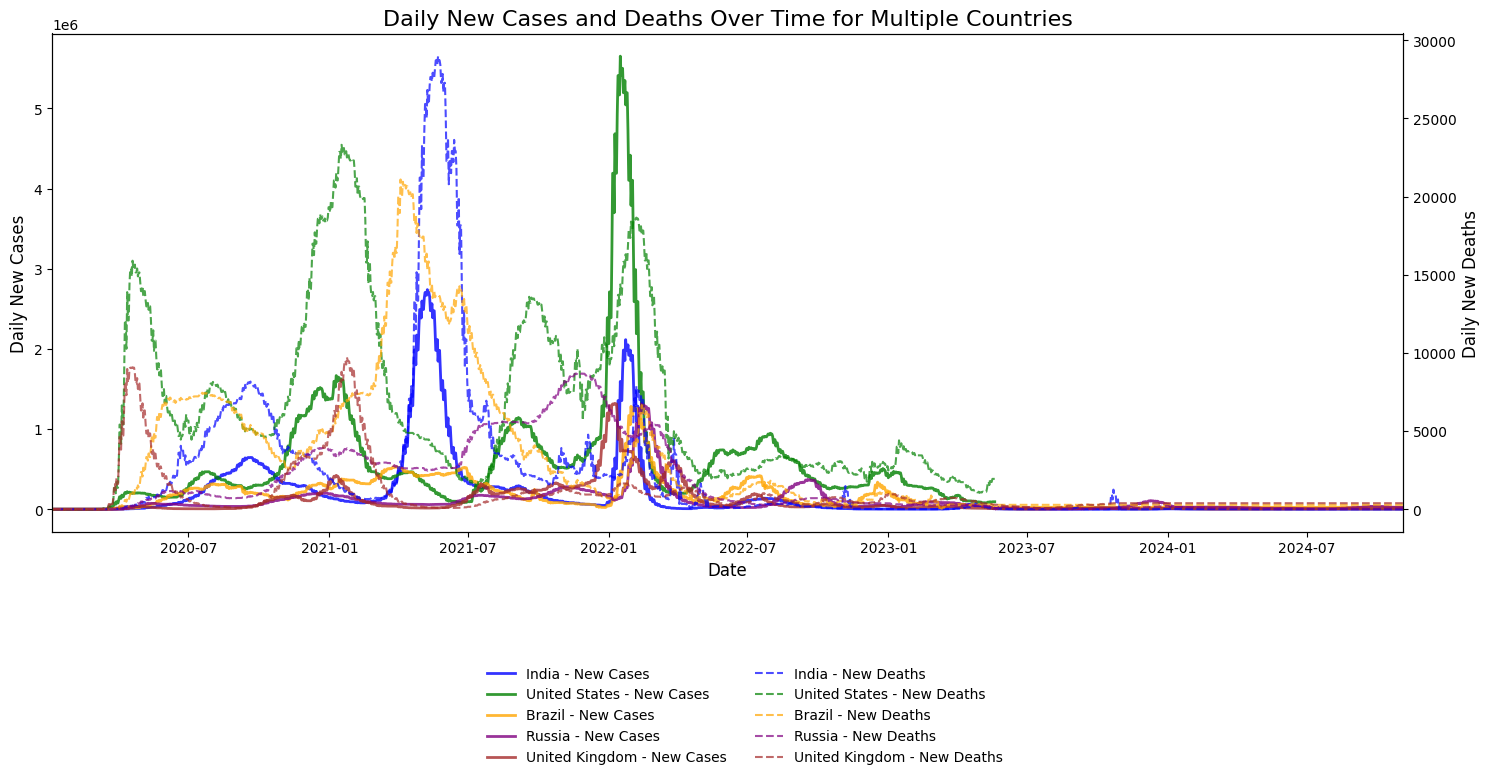

In [32]:
data["date"] = pd.to_datetime(data["date"])
# start_date = "2020-01-01"
# end_date = "2024-01-01"

# filtered_data = data[data["country"] == "India","United States", "Brazil", "Russia", "United Kingdom","China"]
countries = ["India","United States", "Brazil", "Russia", "United Kingdom"]
fig, ax1 = plt.subplots(figsize=(15, 6))

colors = ["blue", "green", "orange", "purple", "brown"]

for i, country in enumerate(countries):
    # Filter data for the specific country
    filtered_data = data[data["country"] == country]
    
    # Plot new cases on the primary y-axis
    ax1.plot(
        filtered_data["date"],
        filtered_data["new_cases"],
        label=f"{country} - New Cases",
        color=colors[i],
        linestyle="-",
        alpha=0.8,
        linewidth=2
    )

# Customize primary y-axis
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Daily New Cases", color="black", fontsize=12)
ax1.tick_params(axis="y", labelcolor="black")

ax1.set_xlim(data["date"].min(), data["date"].max()) # setting the boundary of the x-axis within dataset

# Create a secondary y-axis for new deaths
ax2 = ax1.twinx()

for i, country in enumerate(countries):
    # Filter data for the specific country
    filtered_data = data[data["country"] == country]
    
    # Plot new deaths on the secondary y-axis
    ax2.plot(
        filtered_data["date"],
        filtered_data["new_deaths"],
        label=f"{country} - New Deaths",
        color=colors[i],
        linestyle="--",
        alpha=0.7
    )

# Customize secondary y-axis
ax2.set_ylabel("Daily New Deaths", color="black", fontsize=12)
ax2.tick_params(axis="y", labelcolor="black")

# Add legends for both axes
fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # Adjust position
    ncol=2,  # Number of columns
    fontsize=10,
    frameon=False
)

# Add title
plt.title("Daily New Cases and Deaths Over Time for Multiple Countries", fontsize=16)

# Tight layout for better spacing
plt.tight_layout()
plt.show()




In [33]:

# fig, ax1 = plt.subplots(figsize=(15, 6))

# # Plot new cases on the primary y-axis
# ax1.set_xlabel("Date", fontsize=12)
# ax1.set_ylabel("Daily New Cases", color="blue", fontsize=12)
# ax1.plot(data["date"], data["new_cases"], label="Daily New Cases", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")

# ax1.set_xlim(data["date"].min(), data["date"].max()) # setting the boundary of the x-axis within dataset

# # Create a secondary y-axis for new deaths
# ax2 = ax1.twinx()
# ax2.set_ylabel("Daily New Deaths", color="red", fontsize=12)
# ax2.plot(data["date"], data["new_deaths"], label="Daily New Deaths", color="red",alpha =0.5)
# ax2.tick_params(axis="y", labelcolor="red")

# # ax1.legend(loc="upper left")

# # Add a title
# plt.title("Daily New Cases and Deaths Over Time ", fontsize=16)

# # Tight layout for better spacing
# plt.tight_layout()
# plt.show()




In [34]:

# filtered_data = data[data["country"] == "India"]
# fig, ax1 = plt.subplots(figsize=(15, 6))

# # Plot new cases on the primary y-axis
# ax1.set_xlabel("Date", fontsize=12)
# ax1.set_ylabel("Cumulative Cases", color="green", fontsize=12)
# ax1.plot(filtered_data["date"], filtered_data["total_cases"], label="Cumulative Cases", color="green")
# ax1.tick_params(axis="y", labelcolor="blue")

# ax1.set_xlim(filtered_data["date"].min(), filtered_data["date"].max())

# # Create a secondary y-axis for new deaths
# ax2 = ax1.twinx()
# ax2.set_ylabel("Cumulative Deaths", color="orange", fontsize=12)
# ax2.plot(filtered_data["date"], filtered_data["total_deaths"], label="Cumulative Deaths", color="orange")
# ax2.tick_params(axis="y", labelcolor="red")

# # Add a title
# plt.title("Cumulative Cases and Deaths Over Time for India", fontsize=16)

# # Tight layout for better spacing
# plt.tight_layout()
# plt.show()




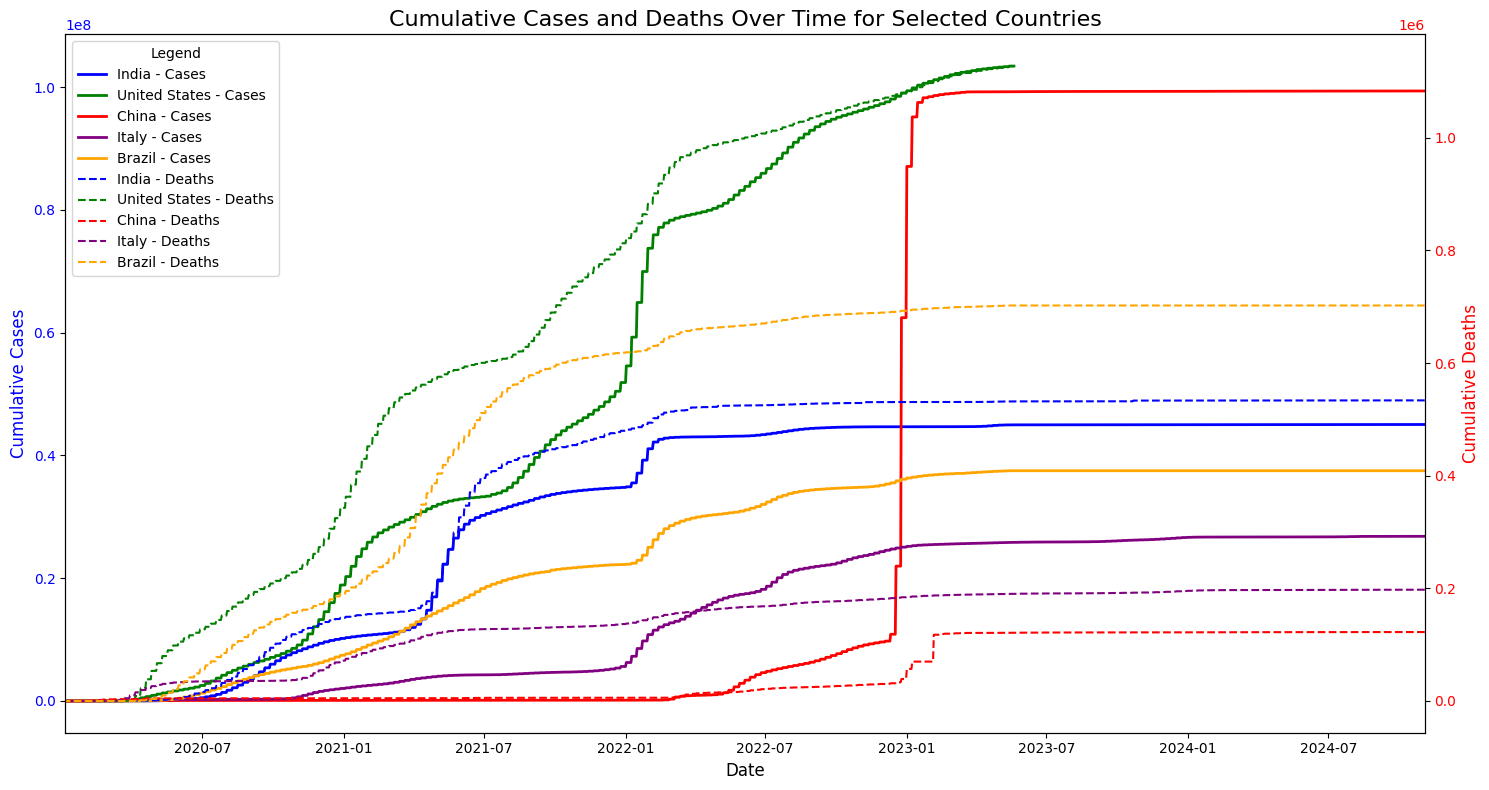

In [35]:
# Filter data for selected countries
countries = ["India", "United States", "China", "Italy", "Brazil"]
filtered_data = data[data["country"].isin(countries)]

# Create a color map for countries
colors = ["blue", "green", "red", "purple", "orange"]
country_color_map = dict(zip(countries, colors))

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot cumulative cases on the primary y-axis
for country in countries:
    country_data = filtered_data[filtered_data["country"] == country]
    ax1.plot(
        country_data["date"],
        country_data["total_cases"],
        label=f"{country} - Cases",
        color=country_color_map[country],
        linewidth=2
    )

ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Cumulative Cases", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlim(data["date"].min(), data["date"].max()) # setting the boundary of the x-axis within dataset
# Add the second y-axis for cumulative deaths
ax2 = ax1.twinx()

# Plot cumulative deaths on the secondary y-axis
for country in countries:
    country_data = filtered_data[filtered_data["country"] == country]
    ax2.plot(
        country_data["date"],
        country_data["total_deaths"],
        linestyle="--",
        label=f"{country} - Deaths",
        color=country_color_map[country],
        linewidth=1.5
    )

ax2.set_ylabel("Cumulative Deaths", color="red", fontsize=12)
ax2.tick_params(axis="y", labelcolor="red")

# Add a title
plt.title("Cumulative Cases and Deaths Over Time for Selected Countries", fontsize=16)

# Combine legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", fontsize=10, title="Legend")

# Tight layout for better spacing
plt.tight_layout()
plt.show()


In [36]:
# data1 = growth_rate.toPandas()
# filtered_data1 = data1[data1["country"] == "India"]
# fig, ax1 = plt.subplots(figsize=(15, 6))

# # Plot new cases on the primary y-axis
# ax1.set_xlabel("Date", fontsize=12)
# ax1.set_ylabel("case_growth_rate", color="blue", fontsize=12)
# ax1.plot(filtered_data1["date"], filtered_data1["case_growth_rate"], label="case_growth_rate", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")

# ax1.set_xlim(data["date"].min(), data["date"].max())

# # Create a secondary y-axis for new deaths
# ax2 = ax1.twinx()
# ax2.set_ylabel("death_growth_rate", color="red", fontsize=12)
# ax2.plot(filtered_data1["date"], filtered_data1["death_growth_rate"], label="death_growth_rate", color="red",alpha = 0.5)
# ax2.tick_params(axis="y", labelcolor="red")

# # Add a title
# plt.title("Daily Growth Rates for Cases and Deaths (for India)", fontsize=16)

# # Tight layout for better spacing
# plt.tight_layout()
# plt.show()


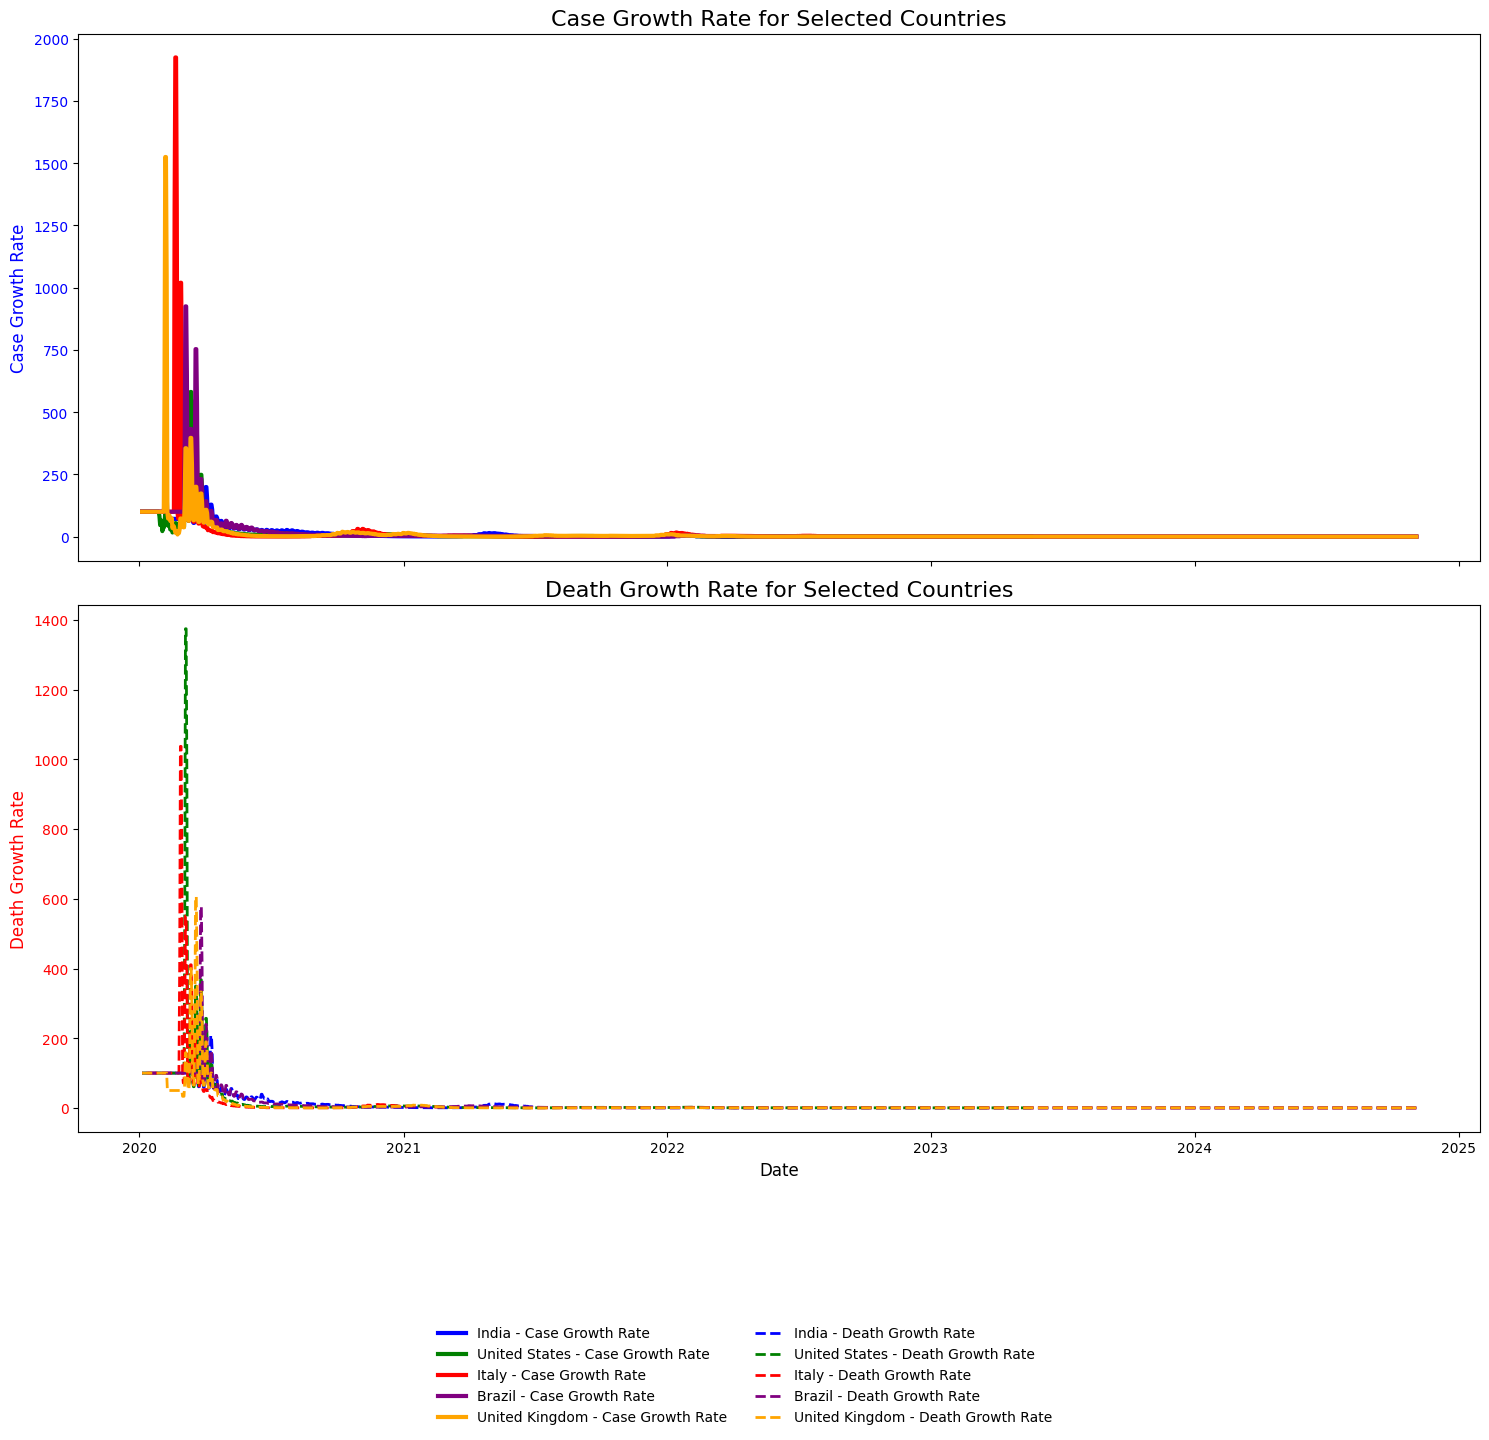

In [55]:

data1= growth_rate.toPandas()
# List of countries to plot
countries = ["India", "United States", "Italy", "Brazil", "United Kingdom"]

# Filter data for selected countries
filtered_data1 = data1[data1["country"].isin(countries)]

# Create a color map for countries
colors = ["blue", "green", "red", "purple", "orange"]
country_color_map = dict(zip(countries, colors))

# Create the figure and two subplots for separate graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot Case Growth Rate on the first subplot (ax1)
for country in countries:
    country_data = filtered_data1[filtered_data1["country"] == country]
    ax1.plot(
        country_data["date"],
        country_data["case_growth_rate"],
        label=f"{country} - Case Growth Rate",
        color=country_color_map[country],
        linewidth=3,
    )

ax1.set_ylabel("Case Growth Rate", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("Case Growth Rate for Selected Countries", fontsize=16)
# ax1.legend(loc="upper left", fontsize=10)



# Plot Death Growth Rate on the second subplot (ax2)
for country in countries:
    country_data = filtered_data1[filtered_data1["country"] == country]
    ax2.plot(
        country_data["date"],
        country_data["death_growth_rate"],
        linestyle="--",
        label=f"{country} - Death Growth Rate",
        color=country_color_map[country],
        linewidth=2,
    )

ax2.set_ylabel("Death Growth Rate", color="red", fontsize=12)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_title("Death Growth Rate for Selected Countries", fontsize=16)
# ax2.legend(loc="upper left", fontsize=10)

# Set x-axis label
ax2.set_xlabel("Date", fontsize=12)

fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # Adjust position
    ncol=2,  # Number of columns
    fontsize=10,
    frameon=False
)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\ACER\AppData\Local\Temp\ipykernel_9252\2875464029.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_cases, x="country", y="new_cases_per_million", palette="Set2")


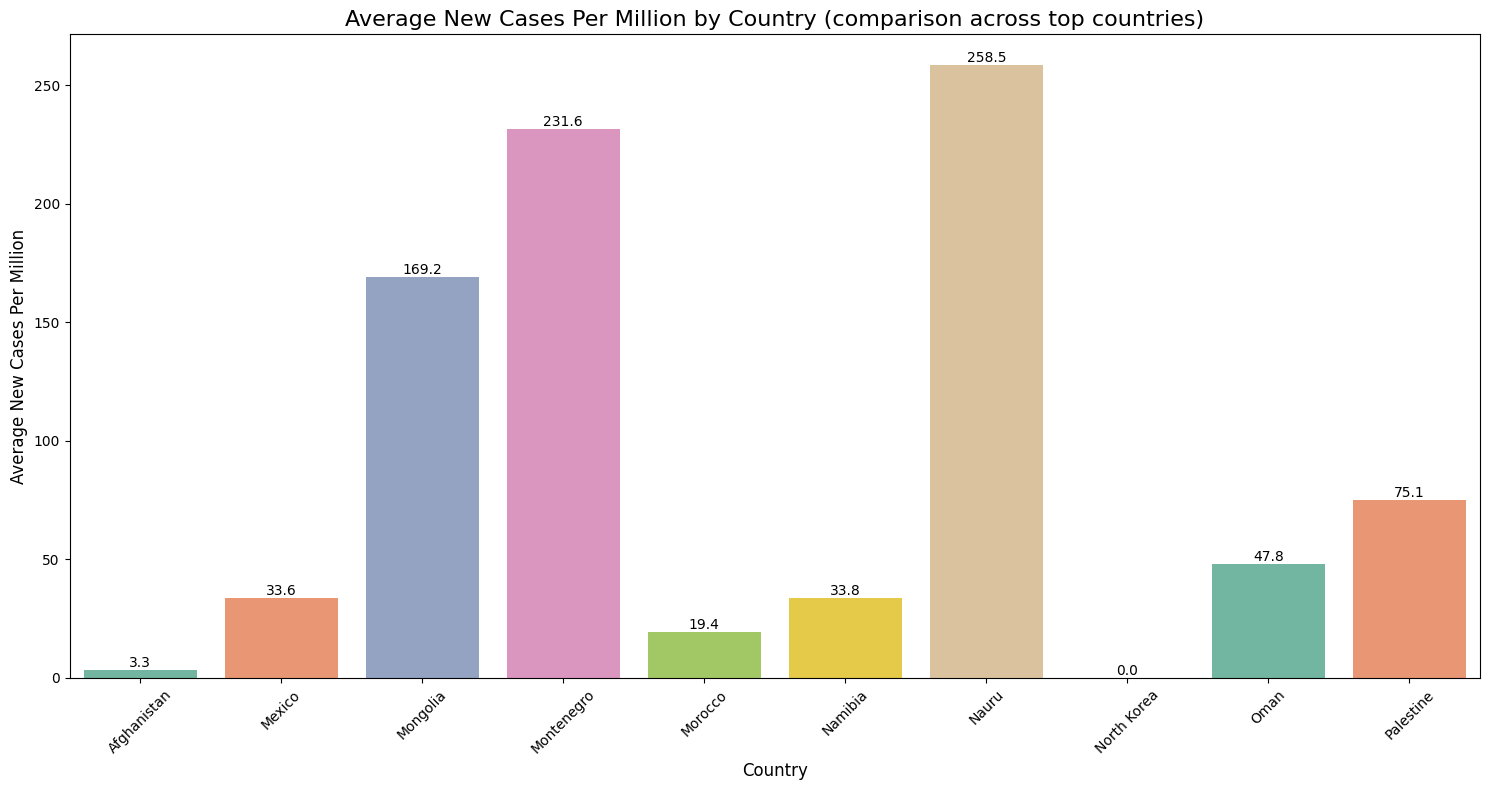

In [60]:
# Calculating average new cases per million for each country
average_cases = filtered_data.groupby("country")["new_cases_per_million"].mean().reset_index()

# Initialize the plot
plt.figure(figsize=(15, 8))
sns.barplot(data=average_cases, x="country", y="new_cases_per_million", palette="Set2")

# Title and labels
plt.title("Average New Cases Per Million by Country (comparison across top countries)", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Average New Cases Per Million", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add data labels
for index, row in average_cases.iterrows():
    plt.text(index, row["new_cases_per_million"], f"{row['new_cases_per_million']:.1f}", ha="center", va="bottom", fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


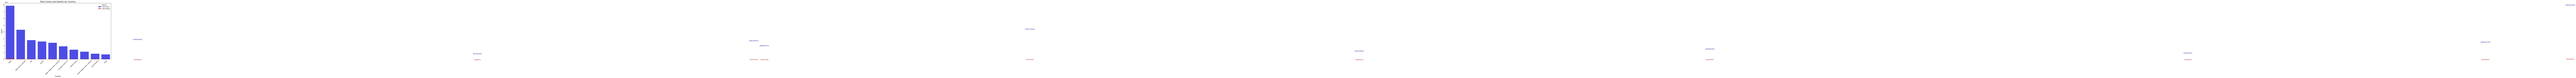

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate data for total cases and deaths by country/region
agg_data = data.groupby("country")[["total_cases", "total_deaths"]].sum().reset_index()

# Sort data for better visualization (descending by total cases)
agg_data = agg_data.sort_values("total_cases", ascending=False).head(10)  # Top 10 countries

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot total cases
sns.barplot(data=agg_data, x="country", y="total_cases", color="blue", label="Total Cases", alpha=0.8)

# Overlay total deaths
sns.barplot(data=agg_data, x="country", y="total_deaths", color="red", label="Total Deaths", alpha=0.7)

# Add labels, title, and legend
plt.title("Total Cases and Deaths by Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Legend", loc="upper right")

# Add data labels
for index, row in agg_data.iterrows():
    plt.text(index, row["total_cases"], f"{int(row['total_cases'])}", ha="center", va="bottom", fontsize=10, color="blue")
    plt.text(index, row["total_deaths"], f"{int(row['total_deaths'])}", ha="center", va="top", fontsize=10, color="red")

# Adjust layout
# plt.tight_layout()
plt.show()


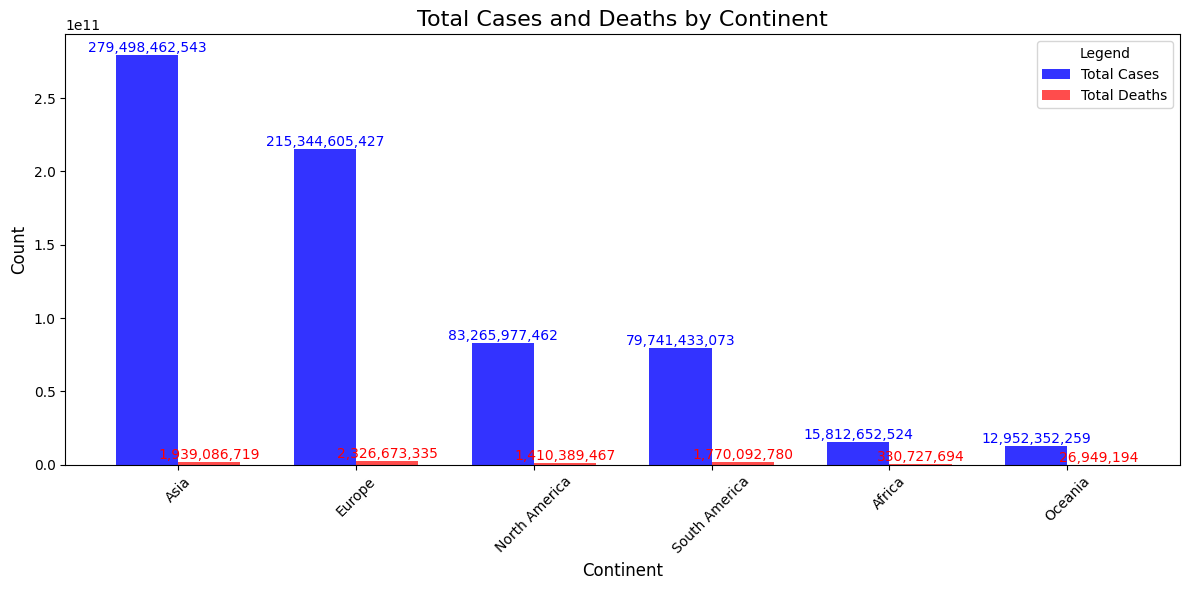

In [67]:

# Aggregate data for total cases and deaths by continent
agg_data = data.groupby("continent")[["total_cases", "total_deaths"]].sum().reset_index()

# Sort data by total cases for better visualization
agg_data = agg_data.sort_values("total_cases", ascending=False)

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width for side-by-side bars
bar_width = 0.35
x = range(len(agg_data["continent"]))

# Plot total cases
ax.bar(x, agg_data["total_cases"], width=bar_width, label="Total Cases", color="blue", alpha=0.8)

# Plot total deaths (side-by-side with total cases)
ax.bar([p + bar_width for p in x], agg_data["total_deaths"], width=bar_width, label="Total Deaths", color="red", alpha=0.7)


ax.set_title("Total Cases and Deaths by Continent", fontsize=16)
ax.set_xlabel("Continent", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xticks([p + bar_width / 2 for p in x])  # Align x-ticks with bars
ax.set_xticklabels(agg_data["continent"], rotation=45)
ax.legend(title="Legend", loc="upper right", fontsize=10)

# Add data labels for total cases
for i, value in enumerate(agg_data["total_cases"]):
    ax.text(i, value, f"{int(value):,}", ha="center", va="bottom", fontsize=10, color="blue")

# Add data labels for total deaths
for i, value in enumerate(agg_data["total_deaths"]):
    ax.text(i + bar_width, value, f"{int(value):,}", ha="center", va="bottom", fontsize=10, color="red")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
# exporting visualizations

# plt.savefig("Total Cases and Death by Continent.png", dpi=500)
